In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048
dtype = None
load_in_4bit = True

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Unsloth: Failed to patch Gemma3ForConditionalGeneration.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-1B-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.51.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

In [4]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.3.19 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


In [5]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 2048, padding_idx=128004)
        (layers): ModuleList(
          (0-15): 16 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lor

In [6]:
chat_prompt = """
### Instruction:
{}

### Input:
{}

### Response:
{}"""

This function ensures the input data aligns with the model’s requirements, reducing inconsistencies during training.

In [7]:
EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instruction = ""
    inputs       = examples["question"]
    outputs      = examples["answers"]
    texts = []
    for input, output in zip(inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = chat_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

In [8]:
from datasets import load_dataset

dataset = load_dataset("KisanVaani/agriculture-qa-english-only",split="train")
dataset = dataset.map(formatting_prompts_func, batched = True,)

README.md:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.97M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/22615 [00:00<?, ? examples/s]

Map:   0%|          | 0/22615 [00:00<?, ? examples/s]

In [9]:
dataset

Dataset({
    features: ['question', 'answers', 'text'],
    num_rows: 22615
})

In [10]:
import pprint
#Here are a few examples of what the data looks like
pprint.pprint(dataset[250])
pprint.pprint(dataset[260])
pprint.pprint(dataset[270])

{'answers': 'organic and inorganic fertilizers',
 'question': 'name two types fertilizers.',
 'text': '\n'
         '### Instruction:\n'
         '\n'
         '\n'
         '### Input:\n'
         'name two types fertilizers.\n'
         '\n'
         '### Response:\n'
         'organic and inorganic fertilizers<|end_of_text|>'}
{'answers': 'Planting ',
 'question': 'which stage of crop cultivation involves placing seeds or '
             'seedlings into the soil at the right depth and spacing.',
 'text': '\n'
         '### Instruction:\n'
         '\n'
         '\n'
         '### Input:\n'
         'which stage of crop cultivation involves placing seeds or seedlings '
         'into the soil at the right depth and spacing.\n'
         '\n'
         '### Response:\n'
         'Planting <|end_of_text|>'}
{'answers': 'nitrogen, phosphorus, and potassium',
 'question': 'which nutrients are required for high yield in cassava.',
 'text': '\n'
         '### Instruction:\n'
         '\n'
   

In [15]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = True,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 200,
        max_steps = 2000,
        learning_rate = 1e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "polynomial",
        seed = 3407,
        output_dir = "outputs",
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/22615 [00:00<?, ? examples/s]

Unsloth: Hugging Face's packing is currently buggy - we're disabling it for now!


In [16]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 22,615 | Num Epochs = 1 | Total steps = 2,000
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 11,272,192/1,000,000,000 (1.13% trained)


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: omaralaa7070 (omaralaa7070-arab-open-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
1,3.094100
2,3.888200
3,3.826100
4,3.960000
5,3.414300
6,2.684200
7,3.125700
8,2.839700
9,3.874700
10,4.147200


Unsloth: Will smartly offload gradients to save VRAM!


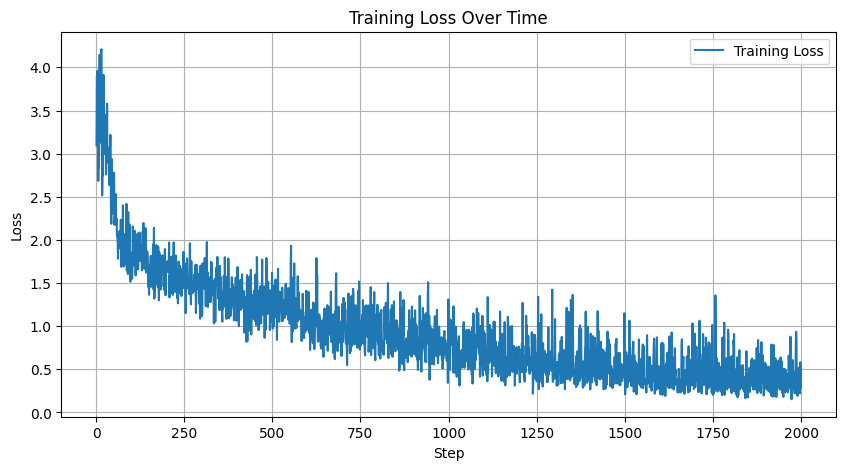

In [21]:
# Convert logs to DataFrame
logs = pd.DataFrame(trainer.state.log_history)

# Filter for training loss
train_logs = logs[logs['loss'].notnull()]

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_logs['step'], train_logs['loss'], label='Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid()
plt.show()

### Testing Model

Trying DataSet Questions

In [23]:
FastLanguageModel.for_inference(model) # For faster Inference

inputs = tokenizer(
[
    chat_prompt.format(
        "", # instruction - leave this blank!
        "what is crop protection?", # input
        "", # output - leave this blank!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

['<|begin_of_text|>\n### Instruction:\n\n\n### Input:\nwhat is crop protection?\n\n### Response:\n Crop protection refers to the various methods used to protect crops from pests, diseases, and other threats<|end_of_text|>']

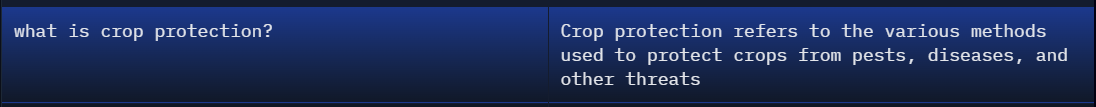

In [24]:
FastLanguageModel.for_inference(model) # For faster Inference

inputs = tokenizer(
[
    chat_prompt.format(
        "", # instruction - leave this blank!
        "what is Integrated Pest Management?", # input
        "", # output - leave this blank!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

['<|begin_of_text|>\n### Instruction:\n\n\n### Input:\nwhat is Integrated Pest Management?\n\n### Response:\nIPM is a holistic approach to pest management that emphasizes the use of multiple methods to control pests, including biological control, cultural control, and chemical control<|end_of_text|>']

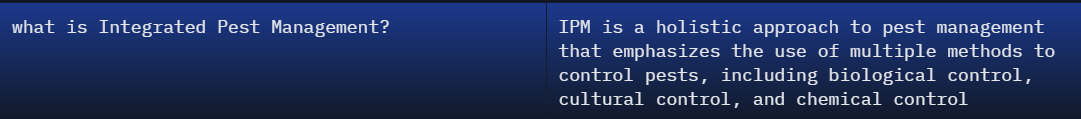

In [25]:
FastLanguageModel.for_inference(model) # For faster Inference

inputs = tokenizer(
[
    chat_prompt.format(
        "", # instruction - leave this blank!
        "what causes plant diseases?", # input
        "", # output - leave this blank!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

['<|begin_of_text|>\n### Instruction:\n\n\n### Input:\nwhat causes plant diseases?\n\n### Response:\nvariety of pathogens, including fungi, bacteria, viruses, and nematodes<|end_of_text|>']

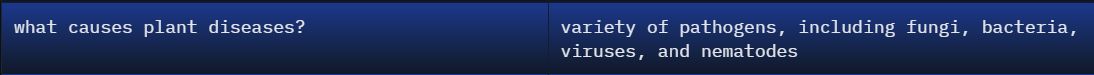

As we can see it nearly matches the dataset examples which means a successful fine-tuning.

Let's Try other random questions

In [26]:
FastLanguageModel.for_inference(model) # For faster Inference

inputs = tokenizer(
[
    chat_prompt.format(
        "", # instruction - leave this blank!
        "What is the best way for fertilizing mint ?", # input
        "", # output - leave this blank!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

["<|begin_of_text|>\n### Instruction:\n\n\n### Input:\nWhat is the best way for fertilizing mint?\n\n### Response:\nFor fertilizing mint, it's best to use a fertilizer that is high in nitrogen and has some phosphorus and potassium. This will help the plants grow and thrive<|end_of_text|>"]

In [27]:
inputs = tokenizer(
[
    chat_prompt.format(
        "", # instruction - leave this blank!
        "What is the best soil for planting tomatoes?", # input
        "", # output - leave this blank!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

['<|begin_of_text|>\n### Instruction:\n\n\n### Input:\nWhat is the best soil for planting tomatoes?\n\n### Response:\nTomatoes prefer well-drained, moderately fertile soil with a pH range of 6.0 to 7.0<|end_of_text|>']

Now Let's Save our model to use it locally with ollama

In [28]:
# Save to 16bit GGUF
if True: model.save_pretrained_gguf("agri_qa_model_new", tokenizer, quantization_method = "f16")

Unsloth: You have 1 CPUs. Using `safe_serialization` is 10x slower.
We shall switch to Pytorch saving, which might take 3 minutes and not 30 minutes.
To force `safe_serialization`, set it to `None` instead.
Unsloth: Kaggle/Colab has limited disk space. We need to delete the downloaded
model which will save 4-16GB of disk space, allowing you to save on Kaggle/Colab.
Unsloth: Will remove a cached repo with size 1.0G


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 5.76 out of 12.67 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 16/16 [00:00<00:00, 17.62it/s]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving agri_qa_model_new/pytorch_model.bin...
Done.


Unsloth: Converting llama model. Can use fast conversion = False.


==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits might take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['f16'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: CMAKE detected. Finalizing some steps for installation.
Unsloth: [1] Converting model at agri_qa_model_new into f16 GGUF format.
The output location will be /content/agri_qa_model_new/unsloth.F16.gguf
This might take 3 minutes...
INFO:hf-to-gguf:Loading model: agri_qa_model_new
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:rope_freqs.weight,           torch.float32 --> F32, shape = {32}
INFO:hf-to-gguf:gguf: loading model part 'pytorch_model.bin'
INFO:hf-to-gguf:token_embd.weight,           torch.float16 --> 